In [4]:
import librosa
import numpy as np
from IPython.display import Audio  #播放套件
import matplotlib.pyplot as plt 
import librosa.display  #libroso 繪圖
import time
import os, re

from sklearn.model_selection import train_test_split

import keras

from keras.models import Sequential, load_model

import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers

In [8]:
npzfile = np.load('df_zero_arr.npz')
print(npzfile.files)
X = npzfile['arr_0']
y = npzfile['arr_1']
print(X.shape, y.shape)

['arr_0', 'arr_1']
(36480, 128, 130) (36480,)


In [9]:
y_onehot = np.eye(10)[y]
y_onehot.shape

(36480, 10)

In [10]:
X = X.swapaxes(1,2)
X.shape

(36480, 130, 128)

In [11]:
X = X.reshape(36480, 130, 128, 1)
X.shape

(36480, 130, 128, 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
y_train.shape

(29184, 10)

# cnn-rnn

In [34]:
num_classes = 10
n_features = X_train.shape[2]
n_time = X_train.shape[1]
nb_filters1=64 
nb_filters2=64 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,3)
pool_size_1= (2,2) 
pool_size_2= (2,2)
pool_size_3 = (2,2)
# dropout_prob = 0.3
dense_size1 = 128
lstm_count = 64
num_units = 120
BATCH_SIZE = 64
EPOCH_COUNT = 200
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)
    
    drop_1 = Dropout(0.3)(pool_1)
    
    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(drop_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)
    
    drop_2 = Dropout(0.3)(pool_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(drop_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    drop_3 = Dropout(0.3)(pool_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(drop_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    drop_4 = Dropout(0.3)(pool_4)
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(drop_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)
    
    drop_5 = Dropout(0.3)(pool_5)

    flatten1 = Flatten()(drop_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
#     flatten2 = K.squeeze(pool_lstm1, axis = -1)
#     dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(lr=0.001)
#     opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [35]:
def train_model(X_train, y_train, X_test, y_test):
    
    n_frequency = 128
    n_frames = 130
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
#     checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_accuracy', verbose=1,
#                                           save_best_only=True, mode='max')
    
    earlystop = EarlyStopping(monitor='val_loss', patience=13, verbose=1, mode='min')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5, min_delta=0.01,
                verbose=1, mode='min'
            )
    callbacks_list = [reducelr_callback]
    

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(X_test, y_test), verbose=1, callbacks=callbacks_list)

    return model, history

In [36]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [37]:
model, history  = train_model(X_train, y_train, X_test, y_test)

Building model...
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 130, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 126, 64  640         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 max_pooling2d_25 (MaxPooling2D  (None, 64, 63, 64)  0           ['conv_1[0][0]']                 
 )                                                                        

C:\Users\User\anaconda3\envs\python_course\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Training...
Epoch 1/200
456/456 [==============================] - 357s 779ms/step - loss: 1.3182 - accuracy: 0.5399 - val_loss: 0.9812 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 2/200
456/456 [==============================] - 460s 1s/step - loss: 0.8813 - accuracy: 0.6976 - val_loss: 0.8312 - val_accuracy: 0.7124 - lr: 0.0010
Epoch 3/200
456/456 [==============================] - 483s 1s/step - loss: 0.7227 - accuracy: 0.7526 - val_loss: 0.6795 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 4/200
456/456 [==============================] - 478s 1s/step - loss: 0.6215 - accuracy: 0.7871 - val_loss: 0.5698 - val_accuracy: 0.7999 - lr: 0.0010
Epoch 5/200
456/456 [==============================] - 485s 1s/step - loss: 0.5404 - accuracy: 0.8142 - val_loss: 0.5100 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 6/200
456/456 [==============================] - 477s 1s/step - loss: 0.4822 - accuracy: 0.8365 - val_loss: 0.4681 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 7/200
456/456 [=================

KeyboardInterrupt: 

In [19]:
model.save('./models/crnn/cnnrnnmodel-bs64-ks33.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


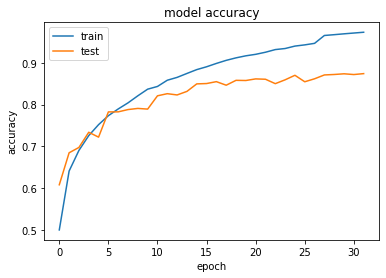

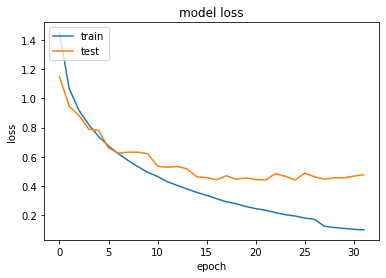

In [22]:
show_summary_stats(history)

In [ ]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis = 1)
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [1,2,3,4,5,6,7,8,9,10]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()